In [8]:
import pandas as pd
from itertools import combinations

## 0. Create test dataset to ease debugging

In [9]:
"""
Select the first 50 families from the clustering file,
and within each family keep at most 5 genes.
"""

# Read original clustering file
df = pd.read_csv("../output/clusters/protein_families_filtered_blast_results_id30_qcov50_scov50_wcol12_network.tsv", sep="\t")

# Get the first 50 unique families
families_to_keep = df["family"].unique()[:50]

# Filter dataset to only those families
df_filtered = df[df["family"].isin(families_to_keep)]

# For each family, keep at most 5 genes
df_short = df_filtered.groupby("family").head(5)

# Save reduced dataset
df_short.to_csv("../output/clusters/protein_families_network_50families_max5.tsv", sep="\t", index=False)


## 1. Generate paralog pairs from clustered families

In [ ]:
# Choose input file: test or full
data = 'test'  

if data == 'test':
    input_path = "../output/clusters/protein_families_network_50families_max5.tsv"
else:
    input_path = "../output/clusters/protein_families_filtered_blast_results_id30_qcov50_scov50_wcol12_network.tsv"
output_path = f"../output/ks/{data}/paralog_pairs.tsv" 

# Read clustering file
df = pd.read_csv(input_path, sep="\t")

# Generate paralog pairs
pairs = []
for fam, group in df.groupby("family"):
    genes = group["geneName"].tolist()
    for g1, g2 in combinations(genes, 2):
        pairs.append((g1, g2, fam))

# Save output
pd.DataFrame(pairs, columns=["gene1", "gene2", "family"]).to_csv(output_path, sep="\t", index=False)


## 2. Extract CDS sequences for paralog pairs

In [29]:
from Bio import SeqIO
import os

# Load paralog pairs from TSV file
pairs = pd.read_csv(f"../output/ks/{data}/paralog_pairs.tsv", sep="\t")

# Read CDS sequences into a dictionary
cds_dict = SeqIO.to_dict(SeqIO.parse("../data/cds.fa", "fasta"))

# Create output folder if it doesn't exist
os.makedirs(f"../output/ks/{data}/cds_pairs", exist_ok=True)

# Loop through each paralog pair and write their CDS sequences to separate FASTA files
for i, row in pairs.iterrows():
    gene1, gene2 = row["gene1"], row["gene2"]
    out_file = f"../output/ks/{data}/cds_pairs/{gene1}_{gene2}.fa"
    with open(out_file, "w") as f:
        SeqIO.write([cds_dict[gene1], cds_dict[gene2]], f, "fasta")


## 3. Align CDS paralog pairs using MAFFT
Implemented as bash script: 3_align_pairs.sh

## 4. Calculate Ka/Ks values with KaKs_Calculator
Implemented as bash script: 4_calculate_ks.sh


## 5. Visualize Ks distribution

In [32]:
import pandas as pd
import glob

files = glob.glob("../output/ks/test/ks_results/*_kaks.txt")

dfs = []
for f in files:
    try:
        df = pd.read_csv(f, sep="\t")
        if not df.empty:
            dfs.append(df)
    except pd.errors.EmptyDataError:
        print(f"Skipping empty file: {f}")

df_all = pd.concat(dfs, ignore_index=True)


Skipping empty file: ../output/ks/test/ks_results\KRG68574_KRH17738_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG68574_KRH17744_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG68574_KRH17748_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG68574_KRH17749_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG87937_KRG89226_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG87937_KRG89246_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG87937_KRG96078_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG88423_KRG89273_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG88427_KRG89182_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG88427_KRG89183_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG88429_KRG88495_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG88429_KRG88528_kaks.txt
Skipping empty file: ../output/ks/test/ks_results\KRG88448_KRG88862_kaks.txt

In [34]:
ks_values = df_all["Ks"].dropna()


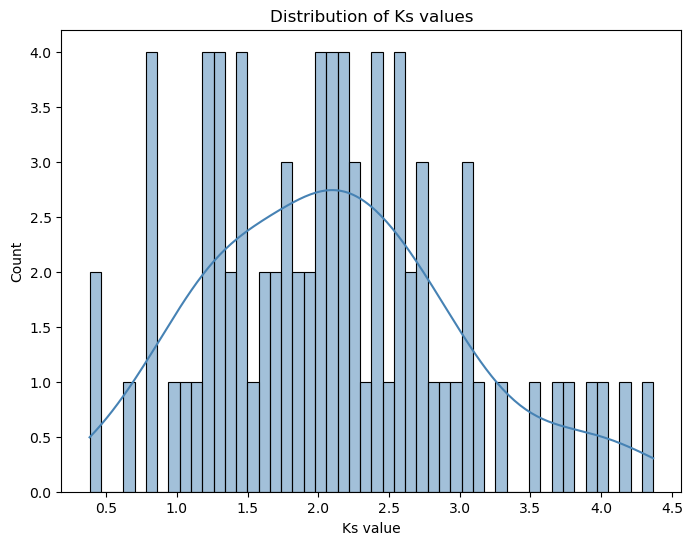

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.histplot(ks_values, bins=50, kde=True, color="steelblue")
plt.xlabel("Ks value")
plt.ylabel("Count")
plt.title("Distribution of Ks values")
plt.show()
